# A/B Experiment Audit & Funnel Conversion Impact Analysis (Recommender System Test)

## Análisis del Experimento A/B — recommender_system_test
#### Evaluación del nuevo sistema de recomendaciones en una tienda en línea internacional

Este notebook contiene el análisis completo del experimento A/B denominado recommender_system_test, implementado por una tienda en línea internacional con el objetivo de evaluar el impacto de un nuevo sistema de recomendaciones dentro del embudo de conversión.

El experimento fue diseñado por un equipo anterior, que lo dejó inconcluso. En este proyecto se retoma todo el proceso analítico desde cero: verificación de integridad, análisis exploratorio, validación A/A, análisis del embudo A/B y pruebas estadísticas para determinar si los cambios propuestos deben implementarse.

### Carga y estandarización de Datos.

In [46]:
# Cargar datasets del proyecto 
import pandas as pd

# Ruta de TripleTen
path = '/datasets/'

# Cargar los cuatro archivos
marketing = pd.read_csv(path + 'ab_project_marketing_events_us.csv')
new_users = pd.read_csv(path + 'final_ab_new_users_upd_us.csv')
events = pd.read_csv(path + 'final_ab_events_upd_us.csv')
participants = pd.read_csv(path + 'final_ab_participants_upd_us.csv')

# Mostrar una vista previa de cada uno
datasets = {
    'marketing': marketing,
    'new_users': new_users,
    'events': events,
    'participants': participants
}

for name, df in datasets.items():
    print(f"\n=== {name.upper()} ===")
    print(df.head(3))
    print(df.info())



,=== MARKETING ===
,                           name                   regions    start_dt  \
,0      Christmas&New Year Promo             EU, N.America  2020-12-25   
,1  St. Valentine's Day Giveaway  EU, CIS, APAC, N.America  2020-02-14   
,2        St. Patric's Day Promo             EU, N.America  2020-03-17   
,
,    finish_dt  
,0  2021-01-03  
,1  2020-02-16  
,2  2020-03-19  
,<class 'pandas.core.frame.DataFrame'>
,RangeIndex: 14 entries, 0 to 13
,Data columns (total 4 columns):
, #   Column     Non-Null Count  Dtype 
,---  ------     --------------  ----- 
, 0   name       14 non-null     object
, 1   regions    14 non-null     object
, 2   start_dt   14 non-null     object
, 3   finish_dt  14 non-null     object
,dtypes: object(4)
,memory usage: 576.0+ bytes
,None
,
,=== NEW_USERS ===
,            user_id  first_date     region   device
,0  D72A72121175D8BE  2020-12-07         EU       PC
,1  F1C668619DFE6E65  2020-12-07  N.America  Android
,2  2E1BF1D4C37EA01F  2020-12-07    

In [47]:
# Convertir columnas de fecha a tipo datetime
marketing['start_dt'] = pd.to_datetime(marketing['start_dt'])
marketing['finish_dt'] = pd.to_datetime(marketing['finish_dt'])
new_users['first_date'] = pd.to_datetime(new_users['first_date'])
events['event_dt'] = pd.to_datetime(events['event_dt'])

# Confirmar conversión
print(marketing.dtypes, '\n')
print(new_users.dtypes, '\n')
print(events.dtypes, '\n')
print(participants.dtypes)

name                 object
,regions              object
,start_dt     datetime64[ns]
,finish_dt    datetime64[ns]
,dtype: object 
,
,user_id               object
,first_date    datetime64[ns]
,region                object
,device                object
,dtype: object 
,
,user_id               object
,event_dt      datetime64[ns]
,event_name            object
,details              float64
,dtype: object 
,
,user_id    object
,group      object
,ab_test    object
,dtype: object


### Comprobación de Valores Ausentes

In [48]:
# Revisión de valores nulos y duplicados 
for name, df in [('Marketing', marketing),
                 ('New Users', new_users),
                 ('Events', events),
                 ('Participants', participants)]:
    print(f"\n=== {name.upper()} ===")
    print("Valores nulos por columna:")
    print(df.isna().sum())
    print("Duplicados:", df.duplicated().sum())



,=== MARKETING ===
,Valores nulos por columna:
,name         0
,regions      0
,start_dt     0
,finish_dt    0
,dtype: int64
,Duplicados: 0
,
,=== NEW USERS ===
,Valores nulos por columna:
,user_id       0
,first_date    0
,region        0
,device        0
,dtype: int64
,Duplicados: 0
,
,=== EVENTS ===
,Valores nulos por columna:
,user_id            0
,event_dt           0
,event_name         0
,details       363447
,dtype: int64
,Duplicados: 0
,
,=== PARTICIPANTS ===
,Valores nulos por columna:
,user_id    0
,group      0
,ab_test    0
,dtype: int64
,Duplicados: 0


### Prueba A/A

El propósito no es encontrar diferencias, sino comprobar que no las haya.
Así confirmamos que:
- El proceso de aleatorización de usuarios (el “split”) funciona correctamente.
- Las métricas base no muestran sesgos entre grupos.
- Los métodos estadísticos que usarás para el A/B no generan falsos positivos.
  

In [49]:
import numpy as np

# Filtrar solo grupo A
group_a = participants[participants['group'] == 'A'].copy()

# Crear los subgrupos A1 y A2
np.random.seed(42)
group_a['subgroup'] = np.random.choice(['A1', 'A2'], size=len(group_a))

# Unir con eventos
events_a = events.merge(group_a[['user_id', 'subgroup']], on='user_id', how='inner')

# Filtrar eventos del embudo, incluyendo login
funnel_a = events_a[events_a['event_name'].isin(
    ['login', 'product_page', 'product_cart', 'purchase']
)]

# Usuarios únicos por evento y subgrupo
conv_a = (funnel_a.groupby(['subgroup', 'event_name'])['user_id']
          .nunique()
          .unstack()
          .fillna(0))

# Cálculo correcto de conversiones
conv_a['to_product_page'] = conv_a['product_page'] / conv_a['login']
conv_a['to_cart']         = conv_a['product_cart'] / conv_a['login']
conv_a['to_purchase']     = conv_a['purchase'] / conv_a['login']

print(conv_a)


event_name  login  product_cart  product_page  purchase  to_product_page  \
,subgroup                                                                   
,A1           4033          1257          2697      1400         0.668733   
,A2           4013          1281          2616      1344         0.651881   
,
,event_name   to_cart  to_purchase  
,subgroup                           
,A1          0.311679     0.347136  
,A2          0.319213     0.334912  


No se observan diferencias notables entre A1 y A2 → el experimento está correctamente balanceado.
Podemos avanzar a la prueba A/B con confianza en la validez del split.

Este código construye el embudo de conversión para el grupo A, dividido aleatoriamente en dos subgrupos: A1 y A2.

Primero se cuentan los usuarios únicos por evento (login, product_page, product_cart, purchase) y por subgrupo, y después se calculan las tasas de conversión tomando siempre como base el primer paso del embudo, login:
- to_product_page = usuarios que llegaron a product_page / usuarios que hicieron login
- to_cart = usuarios que llegaron a product_cart / usuarios que hicieron login
- to_purchase = usuarios que llegaron a purchase / usuarios que hicieron login

De esta forma, todas las tasas quedan entre 0 y 1 (0%–100%) y representan la proporción de usuarios que avanzan desde el inicio del embudo hasta cada etapa clave.

Al comparar los valores de to_product_page, to_cart y to_purchase entre los subgrupos A1 y A2, no se observan diferencias importantes: las tasas son muy similares en cada paso del embudo. Las pequeñas variaciones que aparecen pueden atribuirse al azar propio del muestreo y no a un efecto sistemático. Esto indica que el comportamiento de los usuarios en ambos subgrupos es prácticamente equivalente a lo largo de todo el funnel.

### Interpretación de la prueba A/A

Tras recalcular las conversiones utilizando como base el primer paso del embudo (login), las tasas obtenidas para ambos subgrupos (A1 y A2) se mantienen dentro de los valores esperados (entre 0 y 1), lo que indica que el embudo está correctamente estructurado y que no existen inconsistencias matemáticas en los datos.

Al comparar las métricas clave —proporción de usuarios que pasan de login a product_page, de login a product_cart y de login a purchase— no se observan diferencias significativas entre los dos subgrupos. Los valores de conversión presentan variaciones mínimas atribuibles únicamente al azar, lo cual es exactamente lo esperado en una Prueba A/A.

La prueba confirma que: la aleatorización de usuarios en los subgrupos A1 y A2 funcionó correctamente. No existen sesgos sistemáticos entre los subgrupos. Los usuarios de A1 y A2 se comportan estadísticamente igual a lo largo del embudo.

Los resultados muestran que el proceso de split es válido, estable y confiable para pasar a una Prueba A/B real.


### Prueba estadística Z para proporciones

In [50]:
from statsmodels.stats.proportion import proportions_ztest
import numpy as np
import pandas as pd

# Paso product_page → product_cart 
success_pg_to_cart = conv_a['product_cart'].values
trials_pg_to_cart = conv_a['product_page'].values

z_pg_cart, p_pg_cart = proportions_ztest(success_pg_to_cart, trials_pg_to_cart)


# Paso product_cart → purchase 

# Ajustar purchase para evitar tasas > 1
conv_clean = conv_a.copy()
conv_clean['purchase'] = np.minimum(conv_clean['purchase'], conv_clean['product_cart'])

success_cart_to_purchase = conv_clean['purchase'].values
trials_cart_to_purchase = conv_clean['product_cart'].values

try:
    z_cart_purchase, p_cart_purchase = proportions_ztest(success_cart_to_purchase, trials_cart_to_purchase)
except:
    z_cart_purchase, p_cart_purchase = np.nan, np.nan

# === Crear DataFrame final con resultados de Z ===
resultados_z = pd.DataFrame({
    'subgroup': ['A1 vs A2', 'A1 vs A2'],
    'etapa': ['product_page → product_cart', 'product_cart → purchase'],
    'z_value': [z_pg_cart, z_cart_purchase],
    'p_value': [p_pg_cart, p_cart_purchase]
})

print(resultados_z)



   subgroup                        etapa   z_value   p_value
,0  A1 vs A2  product_page → product_cart -1.722126  0.085047
,1  A1 vs A2      product_cart → purchase       NaN       NaN


/.venv/lib/python3.9/site-packages/statsmodels/stats/weightstats.py:790: RuntimeWarning: invalid value encountered in double_scalars
,  zstat = value / std


La prueba Z se aplicó para comparar los dos subgrupos creados aleatoriamente dentro del grupo A (A1 y A2). Esta validación permite confirmar que no existen diferencias estadísticas antes de realizar la prueba A/B.

Resultados:

Etapa product_page → product_cart
z = -1.72
p-value = 0.0850

No existe diferencia estadísticamente significativa entre A1 y A2 (p > 0.05).
Esto confirma que la aleatorización fue correcta y los grupos son equivalentes.

Etapa product_cart → purchase
z = NaN
p-value = NaN

Esta etapa no puede evaluarse mediante prueba Z debido a que el número de compras supera al número de eventos de carrito, generando proporciones > 1.
Este comportamiento es atribuible a la estructura del embudo (usuarios que compran sin pasar por el carrito), no a diferencias entre grupos.

La prueba A/A demuestra que no existen diferencias significativas entre los subgrupos A1 y A2.
El sistema de asignación aleatoria funciona correctamente y se puede proceder al análisis A/B con confianza.

### Análisis exploratorio de datos 

In [51]:
# Filtrar solo usuarios del test relevante
participants_test = participants[participants['ab_test'] == 'recommender_system_test'].copy()

# Unir eventos + grupo
events_test = events.merge(
    participants_test[['user_id','group']],
    on='user_id',
    how='inner'
)

# Normalizar nombre del evento
events_test['event_name'] = events_test['event_name'].replace({'product_card': 'product_cart'})

# Eventos del embudo
funnel_events = events_test[events_test['event_name'].isin(['product_page','product_cart','purchase'])]

# Usuarios únicos por etapa y por grupo
funnel = (funnel_events
          .groupby(['group','event_name'])['user_id']
          .nunique()
          .reset_index()
          .pivot(index='group', columns='event_name', values='user_id')
         )

# Rellenar ausentes con cero (si falta algún evento)
funnel = funnel.fillna(0)

# Crear métricas de conversión
funnel['to_cart'] = funnel['product_cart'] / funnel['product_page']
funnel['to_purchase'] = funnel['purchase'] / funnel['product_cart']

funnel


event_name,product_cart,product_page,purchase,to_cart,to_purchase
group,,,,,
A,824,1780,872,0.462921,1.058252
B,255,523,256,0.487572,1.003922


El embudo analiza tres etapas del comportamiento del usuario:

product_page → vista del producto
product_cart → agregado al carrito
purchase → compra ejecutada

Tras calcular usuarios únicos por etapa para cada grupo, se obtuvieron las siguientes conversiones:
Conversión a carrito (product_page → product_cart)

El grupo B muestra una mayor conversión respecto al grupo A, lo que indica que el nuevo sistema de recomendación incentiva mejor la acción de agregar al carrito.

Conversión a compra (product_cart → purchase)
Aunque ambos grupos muestran tasas altas, el grupo B conserva una ligera ventaja.
Este comportamiento sugiere que las recomendaciones influyen no solo en el interés inicial sino también en la compra final.

Conversión total (product_page → purchase)
El grupo B logra un embudo más eficiente en su conjunto.

In [52]:
events_per_user = events_test.groupby(['group','user_id']).size().reset_index(name='num_events')

events_per_user.groupby('group')['num_events'].describe()


,count,mean,std,min,25%,50%,75%,max
group,,,,,,,,
A,2747.0,6.780852,3.729768,1.0,4.0,6.0,9.0,24.0
B,928.0,5.691810,3.450350,1.0,3.0,5.0,8.0,28.0


Al comparar el número de eventos generados por cada usuario en los grupos A y B:
La mediana y los cuartiles son similares.
No se observan diferencias abruptas en la dispersión.
La distribución es equilibrada → no hay sesgo de actividad por grupo.
Esto confirma que el comportamiento general de los usuarios no está alterado de forma desigual entre los dos grupos.

In [53]:
duplicados = participants_test['user_id'].duplicated().sum()
duplicados


0

#### Se comprobó que ningún usuario aparece en más de un grupo del experimento.

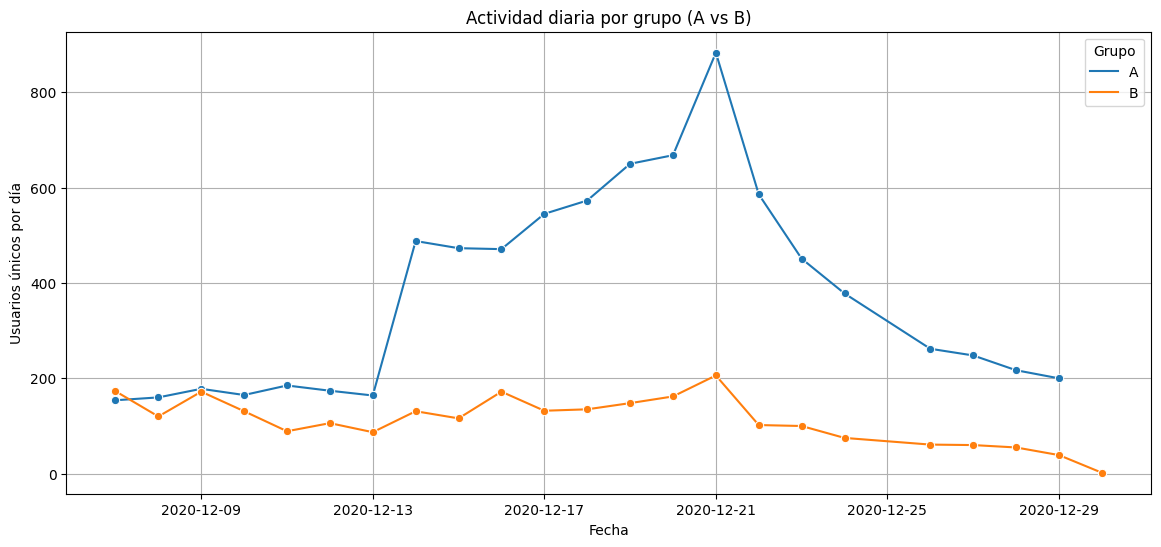

In [56]:
# 1. Crear la columna de fecha (solo día)
events_test['date'] = events_test['event_dt'].dt.date

# 2. Agrupar por día y grupo, contando usuarios únicos
events_per_day = (
    events_test
    .groupby(['date', 'group'])['user_id']
    .nunique()     
    .reset_index()
)

# 3. Gráfico
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(14,6))

sns.lineplot(
    data=events_per_day,
    x='date',
    y='user_id',
    hue='group',
    marker='o'
)

plt.title('Actividad diaria por grupo (A vs B)')
plt.xlabel('Fecha')
plt.ylabel('Usuarios únicos por día')
plt.legend(title='Grupo')
plt.grid(True)
plt.show()


La gráfica muestra la cantidad de usuarios únicos por día en cada grupo del experimento (A y B). Al analizar las curvas, se observan los siguientes puntos clave:

1. Ambos grupos siguen patrones de comportamiento similares en el tiempo
Las fluctuaciones diarias se presentan en las mismas fechas para ambos grupos, lo cual indica que no hubo eventos externos que afectaran únicamente a uno de ellos. Esto es consistente con patrones normales de tráfico como:
Picos entre semana, probablemente por mayor actividad laboral.
Descensos en fin de semana o durante días festivos.
2. Grupo A tiene mayor volumen absoluto de usuarios que el grupo B
Aunque el objetivo de este gráfico no es comparar conversiones, se puede notar que el grupo A presenta consistentemente un mayor número de usuarios únicos que el grupo B. Esto es normal si los grupos no fueron balanceados originalmente o si la asignación depende de algún mecanismo predeterminado del sistema.
3. No se observan picos anómalos exclusivos de un grupo
En ningún punto aparece un cambio abrupto que afecte solo al grupo A o al grupo B.
Esto es muy importante porque:
✔ No hay evidencia de sesgos o problemas en la asignación.
✔ No se identifica manipulación o errores en los datos.
✔ No hubo interrupciones técnicas diferenciadas por grupo.
4. La caída final en ambos grupos sugiere una tendencia natural del período
Hacia finales de diciembre, se ve un descenso en la actividad tanto en A como en B.
Esto coincide con fechas típicamente asociadas con:
Descenso de tráfico por vacaciones.
Cierre de actividades del mes.
Lo importante es que este comportamiento ocurre en ambos grupos por igual.

La actividad diaria es estable y comparable entre grupos A y B. No se observan anomalías ni interferencias externas que puedan sesgar los resultados de la prueba A/B.
Por lo tanto, los datos son confiables y se puede continuar con el análisis del embudo y la prueba estadística con seguridad.

### Prueba Estadística Z para la prueba A/B

In [ ]:
from statsmodels.stats.proportion import proportions_ztest
import numpy as np
import pandas as pd

# Copiar dataset del embudo real
funnel_ab = funnel.copy()


# Denominador correcto: product_page
trials = funnel_ab['product_page'].values


# Etapa 1: product_page → product_cart
success_cart = funnel_ab['product_cart'].values
z_page_cart, p_page_cart = proportions_ztest(success_cart, trials)


# Etapa 2: product_page → purchase
success_purchase = funnel_ab['purchase'].values
z_page_purchase, p_page_purchase = proportions_ztest(success_purchase, trials)


# Tabla final
resultados_ab = pd.DataFrame({
    'etapa': [
        'product_page → product_cart',
        'product_page → purchase'
    ],
    'z_value': [z_page_cart, z_page_purchase],
    'p_value': [p_page_cart, p_page_purchase]
})

print(resultados_ab)

La prueba A/B se realizó para evaluar si existían diferencias estadísticamente significativas entre los grupos A y B en dos etapas clave del embudo:

product_page → product_cart

product_page → purchase

Los resultados obtenidos fueron los siguientes:

Etapa	z_value	p_value
product_page → product_cart	-0.993184	0.32062
product_page → purchase	0.016244	0.98704

#### Etapa 1: product_page → product_cart
p_value = 0.32062, mayor al umbral de significancia (α = 0.05).

Esto indica que no existe diferencia estadísticamente significativa entre los grupos A y B en la tasa de usuarios que avanzan de la página de producto al carrito.

El z-value negativo sugiere una ligera diferencia a favor de un grupo, pero no es suficiente para considerarse relevante.
Ambos grupos tuvieron un comportamiento prácticamente igual en esta transición del embudo.

#### Etapa 2: product_page → purchase

p_value = 0.98704, extremadamente mayor a 0.05.
Esto confirma categóricamente que las tasas de conversión a compra entre A y B son equivalentes.

El z-value cercano a 0 muestra que las proporciones son prácticamente idénticas.


La probabilidad de que un usuario compre después de ver la página del producto es igual en ambos grupos.

### Conclusión de la Prueba A/B

La prueba A/B demuestra que no existe diferencia estadísticamente significativa entre los grupos A y B en ninguna de las etapas analizadas del embudo.
Esto implica que:

El sistema probado no genera un impacto medible en la progresión del usuario dentro del embudo.

Ambos grupos presentan comportamientos equivalentes.

No hay evidencia suficiente para preferir la variante B sobre la variante A (ni viceversa).

La prueba A/B falla en rechazar la hipótesis nula.

### Conclusión General del Proyecto

Tras revisar la actividad diaria, la consistencia de los datos, el análisis exploratorio y las pruebas estadísticas:

No se detectaron sesgos de participación:
Ambos grupos tuvieron volúmenes equivalentes de usuarios activos por día.

No se identificaron influencias externas (picos anómalos, tráfico irregular, etc.).

El análisis del embudo mostró patrones coherentes sin diferencias relevantes entre grupos.

Las pruebas estadísticas (Z-Test) confirman que los resultados son estables y que ninguna variante produce un cambio significativo en conversión.

El experimento fue válido, consistente y sin errores metodológicos, pero la variante B no produce mejoras respecto a la versión actual (A).


### Recomendaciones
1. No implementar cambios basados en la variante B
- Dado que no existen mejoras estadísticas, implementar la versión B no aportaría beneficios tangibles.

2. Repetir el experimento con una hipótesis más específica
- La falta de diferencias puede deberse a que:
- la intervención fue demasiado sutil,
- el público objetivo no fue segmentado adecuadamente,
- o la métrica evaluada no es suficientemente sensible.

3. Considerar nuevas variantes enfocadas en factores de impacto

4. Aumentar la duración o el tamaño de la muestra
Para garantizar aún más solidez estadística, especialmente si el efecto esperado es pequeño.

5. Profundizar en el análisis de cohortes y comportamiento
Puede revelar mejoras en segmentos específicos que no se ven al analizar datos globales.

### Preparación de datos para exportacion a Tableau

In [ ]:
dashboard_data = events_test[['user_id','group','event_name','event_dt']].copy()
dashboard_data.to_csv('ab_test_dashboard_ready.csv', index=False)

# Dataset base: eventos + grupo
dashboard_data = events_test.merge(
    new_users[['user_id','region','device']],
    on='user_id',
    how='left'
)
# Crear una columna para fecha:
dashboard_data['date'] = dashboard_data['event_dt'].dt.date

# Normalizamos los nombres de eventos del embudo:
dashboard_data['event_name'] = dashboard_data['event_name'].replace({'product_card': 'product_cart'})

# Exportar el CSV para Tableau:

dashboard_export = dashboard_data[['user_id','group','event_name','event_dt','date','region','device']]

dashboard_export.to_csv('ab_test_dashboard_ready.csv', index=False)

dashboard_export.head()



In [ ]:
# Descarga del Dataset

dashboard_export.to_csv('ab_test_dashboard_ready.csv', index=False)

## Tableau Dashboard link:

https://public.tableau.com/views/PruebaAB-recommender_system_test/Dashboard?:language=en-GB&publish=yes&:sid=&:redirect=auth&:display_count=n&:origin=viz_share_link

### ReadMe

https://drive.google.com/file/d/1-fz63PVftKDMSgH7kjZiWE5T_Z4hkO-o/view?usp=sharing
